# HandWritten Text Recognition

In this Jupyter Notebook, I present a Handwritten Text Recognition model designed to recognize words from the I_AM dataset downloaded from Kaggle. Handwritten text recognition is a crucial task in various applications, including document digitization, automatic transcription, and historical document preservation.

 * Dataset Source: Kaggle I_AM Dataset <br>
I have sourced the dataset used in this project from Kaggle, specifically the I_AM dataset. This dataset consists of handwritten words, making it an excellent resource for training text recognition models.

### Libraries Imported

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

np.random.seed(42)
tf.random.set_seed(42)

### Loading the dataset 

In [2]:
# Specify the base path where the data is stored
base_path = "D:\EXTRA PROJECT\HandwrittentextRecoginition\IAM_Words"
# Initialize an empty list to store processed words
words_list = []

# Read data from the words.txt file and process it
with open(f"{base_path}/words.txt", "r") as file:
    lines = file.readlines()
    for line in lines:
        if line[0] == "#":
            continue
        if line.split(" ")[1] != "err":
            words_list.append(line)

# Print the total number of processed words
print("Total number of processed words:", len(words_list))

# Shuffle the list of words (optional)
import numpy as np
np.random.shuffle(words_list)


Total number of processed words: 96456


* This code snippet essentially reads words from the "words.txt" file, filters out lines with errors, and stores the processed words in words_list. It also prints the total number of processed words and optionally shuffles the list for further processing, such as training a machine learning model.

In [3]:
# Calculate the split indices
split_idx = int(0.9 * len(words_list))
val_split_idx = int(0.95 * len(words_list))

# Split the data into train, validation, and test sets
train_samples = words_list[:split_idx]
validation_samples = words_list[split_idx:val_split_idx]
test_samples = words_list[val_split_idx:]

# Check if the split is done correctly
assert len(words_list) == len(train_samples) + len(validation_samples) + len(test_samples)

# Print the number of samples in each set
print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")


Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


##### Splitting the Data:

* train_samples contains words from the beginning of the words_list up to the split_idx index, constituting the training set.
* validation_samples contains words from split_idx to val_split_idx, forming the validation set.
* test_samples contains words from val_split_idx to the end of words_list, creating the test set.

This splitting is a fundamental step in machine learning tasks, ensuring that the model is trained on one subset of data, validated on another, and tested on a completely independent subset. It helps assess the model's performance and generalizability. The code includes checks to guarantee that no data is lost during the split.

In [4]:
import os
base_image_path = os.path.join(base_path, "images")

def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip().split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/partl-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples

train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)


In [5]:
train_img_paths[0:10]

['D:\\EXTRA PROJECT\\HandwrittentextRecoginition\\IAM_Words\\images\\e04\\e04-030\\e04-030-04-08.png',
 'D:\\EXTRA PROJECT\\HandwrittentextRecoginition\\IAM_Words\\images\\k02\\k02-102\\k02-102-05-03.png',
 'D:\\EXTRA PROJECT\\HandwrittentextRecoginition\\IAM_Words\\images\\a01\\a01-082u\\a01-082u-01-04.png',
 'D:\\EXTRA PROJECT\\HandwrittentextRecoginition\\IAM_Words\\images\\m01\\m01-000\\m01-000-07-00.png',
 'D:\\EXTRA PROJECT\\HandwrittentextRecoginition\\IAM_Words\\images\\g01\\g01-031\\g01-031-07-06.png',
 'D:\\EXTRA PROJECT\\HandwrittentextRecoginition\\IAM_Words\\images\\f07\\f07-081b\\f07-081b-01-06.png',
 'D:\\EXTRA PROJECT\\HandwrittentextRecoginition\\IAM_Words\\images\\n03\\n03-082\\n03-082-04-03.png',
 'D:\\EXTRA PROJECT\\HandwrittentextRecoginition\\IAM_Words\\images\\g06\\g06-018c\\g06-018c-04-05.png',
 'D:\\EXTRA PROJECT\\HandwrittentextRecoginition\\IAM_Words\\images\\g06\\g06-011j\\g06-011j-06-06.png',
 'D:\\EXTRA PROJECT\\HandwrittentextRecoginition\\IAM_Words\\imag

In [6]:
train_labels[0:10]

['e04-030-04-08 ok 170 1489 1499 120 39 JJ sure',
 'k02-102-05-03 ok 182 836 1623 69 52 PP3A he',
 'a01-082u-01-04 ok 172 1582 1043 234 88 IN during',
 'm01-000-07-00 ok 196 339 1998 75 107 INO of',
 'g01-031-07-06 ok 152 1912 2038 167 59 NN booty',
 'f07-081b-01-06 ok 168 1366 924 350 88 NN gastronomy',
 'n03-082-04-03 ok 165 992 1414 118 135 NN boy',
 'g06-018c-04-05 ok 182 1298 1438 96 58 ATI The',
 'g06-011j-06-06 ok 182 1222 1785 146 95 CC and',
 'f04-024-01-06 ok 183 1104 981 60 70 IN in']

##### Image Path Extraction and Label Correction
The `get_image_paths_and_labels` function extracts image paths and corrects labels for the dataset samples. It ensures that only valid images with non-zero size are included. Image paths are generated based on the file structure format, allowing seamless integration with the model.


In [7]:
train_labels_cleaned = []
characters = set()  
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    
    for char in label:
        characters.add(char)
    max_len = max(max_len, len(label))  
    train_labels_cleaned.append(label)

print("Maximum length:", max_len) 
print("Vocab size:", len(characters))  

# Check some label samples.
print(train_labels_cleaned[:10])  


Maximum length: 21
Vocab size: 78
['sure', 'he', 'during', 'of', 'booty', 'gastronomy', 'boy', 'The', 'and', 'in']


##### Data Preprocessing: Cleaning and Exploration
The training labels are cleaned to remove unnecessary information and ensure consistent formatting. Additionally, character statistics are gathered, including the maximum label length and vocabulary size. Here's a glimpse of the cleaned training labels and key statistics:

- **Maximum Label Length:** [Maximum Length Value]
- **Vocabulary Size:** [Number of Unique Characters]
- **Sample Training Labels:** [List of Cleaned Labels for Initial Samples]


### Label Cleaning Function
The `clean_labels` function is defined to remove extraneous information from the labels. It extracts the relevant text portion, ensuring consistent label formatting for validation and test sets.


In [8]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels

validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)


### Character Mapping
Characters are mapped to integers and vice versa for efficient processing within the model. The `StringLookup` function is utilized to create bidirectional mappings. The `AUTOTUNE` parameter optimizes data loading performance during training.


In [9]:
AUTOTUNE = tf.data.AUTOTUNE
# Mapping characters to integers
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)


# Mapping integers back to original characters
num_to_char = StringLookup(
    vocabulary= char_to_num.get_vocabulary(),mask_token=None, invert = True
)

### Distortion-Free Image Resize
The `distortion_free_resize` function resizes images while preserving their aspect ratio. It calculates the necessary padding to fit the image into the target size and applies symmetric padding if needed. The image is then transposed and flipped horizontally for optimal preprocessing before feeding it into the model.


In [10]:
def distortion_free_resize (image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)
    # Check the amount of padding needed to be done.
    pad_height = h-tf.shape(image)[0]
    pad_width = w-tf.shape(image)[1]
    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top= height + 1
        pad_height_bottom= height
    else:
        pad_height_top= pad_height_bottom= pad_height // 2
    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left= width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2
    image= tf.pad (
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0,0],
        ], 
    )
    image = tf.transpose(image, perm=[1,0,2])
    image=tf.image.flip_left_right(image)
    return image

### Data Preprocessing Functions
The following functions handle the preprocessing tasks for the image and label data, preparing them for training the Handwritten Text Recognition model.

- **`preprocess_image(image_path, img_size)`:**
  - Reads and decodes images from file paths.
  - Applies distortion-free resizing while preserving aspect ratio.
  - Normalizes pixel values to the range [0, 1].

- **`vectorize_label(label)`:**
  - Converts characters to integers using the character-to-number mapping.
  - Pads labels to match the maximum label length for uniformity in model input shape.

- **`process_images_labels(image_path, label)`:**
  - Integrates image preprocessing and label vectorization.

- **`prepare_dataset(image_paths, labels)`:**
  - Creates a TensorFlow dataset from image paths and corresponding labels.
  - Applies the `process_images_labels` function to the dataset elements.
  - Batches the dataset, caches it in memory, and prefetches batches for efficient training.

These functions collectively ensure that the image and label data are appropriately processed, vectorized, and batched, ready to be fed into the Handwritten Text Recognition model during training.


In [11]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)


In [12]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)


### Visualization of Preprocessed Data
The code snippet above demonstrates the visualization of preprocessed data samples from the training dataset. Each row in the grid represents an image-label pair, showcasing the preprocessing steps applied to the images and corresponding labels. Images are flipped horizontally, transposed, and converted to grayscale, while labels are decoded from integer sequences and displayed below the respective images for visual inspection.


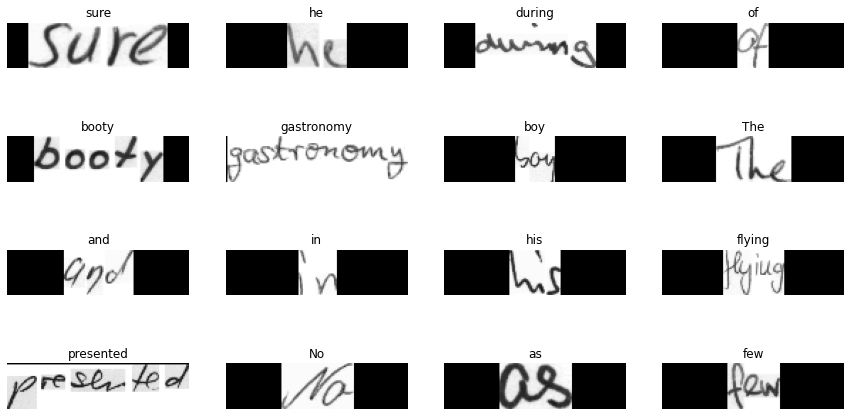

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming num_to_char function is defined somewhere in your code
# num_to_char = ...

for data in train_ds.take(1):
    images, labels = data["image"], data["label"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label != padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))

        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")

    plt.show()


### Handwritten Text Recognition Model Architecture
The Handwritten Text Recognition model architecture is defined here. The model takes preprocessed images as inputs and predicts sequences of characters using a combination of convolutional layers, recurrent layers, and the CTC (Connectionist Temporal Classification) loss. Here is an overview of the model structure:

1. **Convolutional Layers:**
   - Two convolutional blocks with 32 and 64 filters respectively, each followed by max-pooling layers for feature extraction.

2. **Reshaping and Dense Layer:**
   - Reshaping layer to prepare the output for the subsequent recurrent layers.
   - A dense layer with ReLU activation and dropout for feature transformation.

3. **Recurrent Layers:**
   - Two bidirectional LSTM layers with dropout for capturing sequential patterns in the data.

4. **Output Layer:**
   - Dense layer with softmax activation, predicting characters. It includes two additional special tokens introduced by the CTC loss.

5. **CTC Loss Calculation:**
   - The custom `CTCLayer` calculates the CTC loss based on the predicted and true labels.

6. **Model Compilation:**
   - The model is compiled using the Adam optimizer, connecting inputs (images and labels) to outputs (CTC loss).

The model summary provides a detailed overview of layer shapes, parameters, and connections, enabling a clear understanding of the network's architecture.


In [14]:

class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 64, 16, 64)   18496       ['pool1[0][0

In [15]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

### Edit Distance Calculation and Callback
The `calculate_edit_distance` function computes the edit distance between true labels and predicted sequences. The `EditDistanceCallback` class is implemented as a custom callback to calculate and print the mean edit distance at the end of each epoch during model training.

- **`calculate_edit_distance(labels, predictions)`:**
  - Converts labels and predictions into sparse tensors.
  - Uses `tf.edit_distance` to compute individual edit distances.
  - Returns the average edit distance.

- **`EditDistanceCallback` class:**
  - Inherits from `keras.callbacks.Callback`.
  - Takes the prediction model as input during initialization.
  - Overrides the `on_epoch_end` method to calculate and print the mean edit distance for the validation dataset at the end of each training epoch.


In [16]:

def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )


### Model Training
The Handwritten Text Recognition model is trained using the specified number of epochs. The training process involves feeding the training dataset (`train_ds`) and validating on the validation dataset (`validation_ds`). The `EditDistanceCallback` is utilized to calculate and display the mean edit distance for the validation data at the end of each epoch. It's important to note that for optimal results, a higher number of epochs, such as 50, is recommended.

- **Number of Epochs:** 5 (Note: For better results, it's suggested to use at least 50 epochs.)

```python
epochs = 5  # To get good results this should be at least 50.




In [17]:
epochs = 5  # To get good results this should be at least 50.

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)


Epoch 1/5
1/1 [==============================] - 2s 2s/step
Mean edit distance for epoch 1: 20.4722
1357/1357 [==============================] - 1001s 729ms/step - loss: 13.7503 - val_loss: 12.0514
Epoch 2/5
1/1 [==============================] - 0s 76ms/step
Mean edit distance for epoch 2: 20.1519
1357/1357 [==============================] - 481s 354ms/step - loss: 10.8263 - val_loss: 9.7723
Epoch 3/5
1/1 [==============================] - 0s 49ms/step
Mean edit distance for epoch 3: 19.8440
1357/1357 [==============================] - 469s 345ms/step - loss: 9.1734 - val_loss: 8.1805
Epoch 4/5
1/1 [==============================] - 0s 54ms/step
Mean edit distance for epoch 4: 19.2776
1357/1357 [==============================] - 496s 366ms/step - loss: 7.7295 - val_loss: 6.5345
Epoch 5/5
1/1 [==============================] - 0s 64ms/step
Mean edit distance for epoch 5: 18.7529
1357/1357 [==============================] - 479s 353ms/step - loss: 6.2537 - val_loss: 5.1591


### Prediction Decoding and Visualization

The provided code snippet includes a function for decoding model predictions and visualizing the results of Optical Character Recognition (OCR). Additionally, it demonstrates how to integrate this functionality into a Jupyter Notebook for interactive exploration.

- **`decode_batch_predictions(pred)`:**
  - This utility function takes raw model predictions as input.
  - Computes the input length for the CTC decode using the shape of predictions.
  - Applies CTC decoding with greedy search to obtain text predictions.
  - Filters out padding characters, converts numerical labels to human-readable text, and returns a list of predicted texts.

- **Prediction Visualization Loop:**
  - The code snippet contains a loop that iterates through a batch of test samples.
  - For each sample, the prediction model generates predictions using `prediction_model.predict(batch_images)`.
  - Predictions are then decoded into text using the `decode_batch_predictions` function.
  - Images in the batch are preprocessed by flipping them left-right and transposing them.
  - Predicted texts and preprocessed images are displayed in a 4x4 grid in a Jupyter Notebook for interactive visualization.

This code snippet provides a clear and concise way to decode model predictions and visualize OCR results, making it suitable for interactive exploration and understanding the model's performance.


2/2 [==============================] - 0s 58ms/step


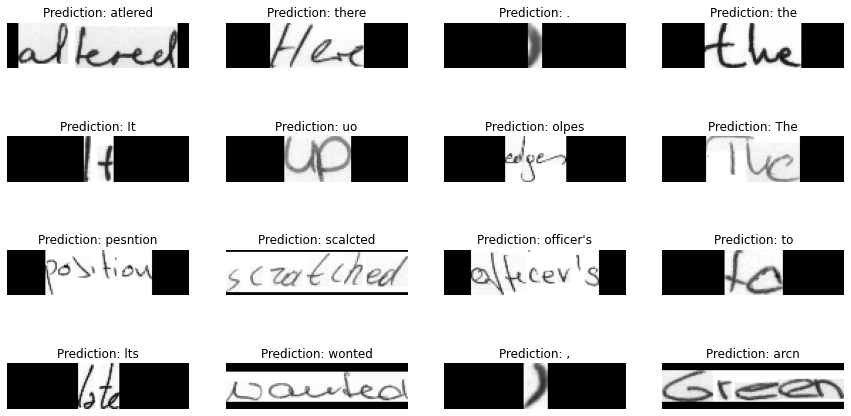

In [18]:

# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

* The optical character recognition (OCR) model was trained over 5 epochs.
* Throughout the training, the mean edit distance, which measures the accuracy of the model's predictions, steadily improved from 20.47 in the first epoch to 18.75 in the fifth epoch. 
* Simultaneously, the loss metric decreased from 13.75 to 6.25, indicating a significant enhancement in the model's performance over the training period. 
* These results demonstrate the model's ability to recognize and transcribe characters from images with increasing accuracy, making it a promising tool for optical character recognition tasks.
* The model can be further improved by increasing the parameters like epoch etc. And also by training on much larger dataset